# ASQUIRE DATA LOADING

In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from scipy import signal
import soundfile as sf
import pandas as pd
import numpy as np
import subprocess
import functools
import librosa
import shutil
import glob
import json
import os

from lib.asqlib import *

## DATA PATHS

In [3]:
EXP_VER = "v12"
REPORT_FOLDER = f"report_{EXP_VER}"

ASQ_MUSTER_CSV = f"{REPORT_FOLDER}/asquire_corpus_muster.csv"
ASQ_LABELS_CSV = f"{REPORT_FOLDER}/all_asq_aud_anotes.csv"

In [4]:
pd.read_csv(ASQ_MUSTER_CSV)

,index,sub_id,age,gender,height,weight,meta-data--file_path,anot--meta-data--file_path,breath--file_path,anot--breath--file_path,...,uu--file_path,anot--uu--file_path,yee--file_path,anot--yee--file_path,zz--file_path,anot--zz--file_path,sent--file_path,anot--sent--file_path,~noise~--file_path,anot--~noise~--file_path
0,0,qwer-0177a438,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,1,bugsbunny-13f848d8,-,-,-,-,-,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,...,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-,report_v12/asquire_data/bugsbunny-13f848d8/web...,-
2,2,doll-808ed97a,-,-,-,-,-,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,...,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-,report_v12/asquire_data/doll-808ed97a/webapp-a...,-
3,3,varun-8f78ac35,-,-,-,-,-,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,...,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-,report_v12/asquire_data/varun-8f78ac35/webapp-...,-
4,4,murugeswari-d700dff3,-,-,-,-,-,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,...,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-,report_v12/asquire_data/murugeswari-d700dff3/w...,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,harisk-6f82d610,58,m,175,88,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,...,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,-,-,report_v12/asquire_data/harisk-6f82d610/webapp...,report_v12/asquire_data/harisk-6f82d610/webapp...,-,-,-,-
228,228,arhaam-350fc3e6,6,m,114,30,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,report_v12/asquire_data/arhaam-350fc3e6/webapp...,-,-,-,-,-,-,-,-
229,229,ravisk-cd186836,60,m,177,83,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,report_v12/asquire_data/ravisk-cd186836/webapp...,-,-,-,-
230,230,srinivas-b89febe6,60,m,172,85,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,report_v12/asquire_data/srinivas-b89febe6/weba...,-,-,-,-


In [5]:
pd.read_csv(ASQ_LABELS_CSV)["label"].unique()

array(['oo', 'yy', 'cc', 'ss', 'aa', 'uu', 'ii', 'xx', 'ee', 'zz', 'ii-n'],
      dtype=object)

In [6]:
pd.read_csv(ASQ_LABELS_CSV).columns

Index(['app_code', 'sub_id', 'file_class', 'file_xindex', 'score',
       'file_format', 'file_name', 'file_path', 'file_match',
       'anot--file_format', 'anot--file_name', 'anot--file_path', 'age',
       'gender', 'height', 'weight', 'start', 'end', 'label', 'line_number',
       'dur'],
      dtype='object')

In [126]:
class DataFolds(DataStaticInfo):

    LABELS = ['aa', 'ee', 'uu', 'oo', 'ii', 'xx', 'cc', 'yy', 'ss',  'zz', 'ii-n']
    VOW_LABELS = ['aa', 'ee', 'uu']

    PAD = 0.0
    WIN_DUR = 0.52
    MIN_VOWEL_DUR = 16.0

    FOLD_k = "fold"
    TOTAL_k = "total"

    ASQ_SUBJECT_LABEL_STAT_FNAME = "asq_subject_label_stats"
    ASQ_SUBJECT_VOWEL_FOLDS_FNAME = "asq_subject_vowel_folds"

    N_FOLDS: int

    ASQ_ANNOTATION_DF: pd.DataFrame
    SUB_LABEL_STAT_DF: pd.DataFrame
    ASQ_VOWEL_FOLD_DF: pd.DataFrame

    def __init__(self, annotation_csv: str, folds: int = 5) -> None:

        self.N_FOLDS = folds
        self.ASQ_ANNOTATION_DF = pd.read_csv(annotation_csv)
        self.SUB_LABEL_STAT_DF = self.sub_label_stat()
        self.ASQ_VOWEL_FOLD_DF = self.sub_vowel_filt()
        self.ASQ_VOWEL_SPLIT_DF = self.split_chunks(self.ASQ_VOWEL_FOLD_DF)

    
    def sub_label_stat(self, label_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_df) == pd.DataFrame:
            label_df = self.ASQ_ANNOTATION_DF

        label_df = label_df.copy()

        sub_dicts = []
        for sid in self.get_subjects():

            
            filt = label_df[self.fkeys['SID']] == sid
            sub_df: pd.DataFrame = label_df[filt]
            
            sub_dict = {
                f"{self.fkeys['SID']}": sid,
            } | sub_df.iloc[0][[self.GENDER_k, self.AGE_k]].to_dict()

            sub_dict[self.TOTAL_k] = sub_df[self.DUR_k].sum()

            for label in self.LABELS:
                filt = sub_df[self.LABEL_k] == label
                sub_label_stats_df = sub_df[filt]

                # count = sub_label_df.shape[0]
                total_dur = np.round(sub_label_stats_df[self.DUR_k].sum(), 2)
                mean_dur = np.round(sub_label_stats_df[self.DUR_k].mean(), 2)
                std_dur = np.round(sub_label_stats_df[self.DUR_k].std(), 2)
                cov = np.round(std_dur/mean_dur, 2)
                
                sub_dict[f"{label}_count"] = sub_label_stats_df.shape[0]
                sub_dict[f"{label}_dur"] = total_dur
                sub_dict[f"{label}_mean"] = mean_dur
                sub_dict[f"{label}_std"] = std_dur
                sub_dict[f"{label}_cov"] = cov

            sub_dicts.append(sub_dict)

        sub_label_stats_df =  pd.DataFrame(sub_dicts)
        sub_label_stats_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)


        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_LABEL_STAT_FNAME}.csv")
        
        sub_label_stats_df.to_csv(export_path, index=False)
        
        return sub_label_stats_df
    

    def sub_vowel_filt(self, label_stat_df: pd.DataFrame|bool=False) -> pd.DataFrame:

        if not type(label_stat_df) == pd.DataFrame:
            label_stat_df = self.SUB_LABEL_STAT_DF

        label_stat_df = label_stat_df.copy()

        # duration filter
        filts = [label_stat_df[f"{l}_dur"] > self.MIN_VOWEL_DUR for l in self.VOW_LABELS]
        filt = functools.reduce(lambda p, c: p & c, filts)

        vowel_stat_df = label_stat_df[filt]

        cols = ['sub_id', self.AGE_k, self.GENDER_k]
        cols += vowel_stat_df.columns[vowel_stat_df.columns.str.contains('|'.join(self.VOW_LABELS))].tolist()
        vowel_stat_df = vowel_stat_df[cols]

        dur_cols = vowel_stat_df.columns[vowel_stat_df.columns.str.contains(self.DUR_k)].tolist()
        vowel_stat_df[self.TOTAL_k] = vowel_stat_df[dur_cols].sum(axis=1)
        vowel_stat_df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        genders = ['f', 'm']

        vowel_folds_dfs = [self.make_folds(self.gender_filter(vowel_stat_df, g), self.N_FOLDS) for g in genders]

        vowel_folds_df =  pd.concat(vowel_folds_dfs)

        filt_subjects = self.get_subjects(vowel_folds_df)

        filt = self.ASQ_ANNOTATION_DF[self.fkeys['SID']].isin(filt_subjects)
        filt &= self.ASQ_ANNOTATION_DF[self.LABEL_k].isin(self.VOW_LABELS)


        vowel_filt_df = self.ASQ_ANNOTATION_DF[filt]

        vowel_filt_df = vowel_filt_df.merge(vowel_folds_df[[self.fkeys['SID'], self.FOLD_k]], on=[self.fkeys['SID']])

        export_path = os.path.join(REPORT_FOLDER, 
                                   f"{self.ASQ_SUBJECT_VOWEL_FOLDS_FNAME}_{self.N_FOLDS}.csv")

        vowel_filt_df.to_csv(export_path, index=False)

        return vowel_filt_df
    

    def split_chunks(self, df: pd.DataFrame, win_dur=0.5) -> pd.DataFrame:
        df = df.copy()

        new_rows = []
        for i, row in df.iterrows():
            start = row[self.BEGIN_k]
            end = row[self.END_k]
            dur = row[self.DUR_k]

            segments = np.floor(dur/self.WIN_DUR)

            for i in range(int(segments)):
                new_start = start + i*self.WIN_DUR
                new_end = new_start + self.WIN_DUR

                new_row = row.copy()
                new_row[self.BEGIN_k] = new_start
                new_row[self.END_k] = new_end
                new_row[self.DUR_k] = self.WIN_DUR

                new_rows.append(new_row)

        new_df = pd.DataFrame(new_rows)    

        return new_df


    def make_folds(self, df: pd.DataFrame, n) -> pd.DataFrame:
        df = df.copy()

        df.sort_values(by=[self.TOTAL_k], inplace=True, ascending=False)

        groups = []
        group_sums = np.zeros(n)

        for _, rv in df.iterrows():
            # Find the group with the smallest sum and assign the current row to it
            min_sum_index = np.argmin(group_sums)
            groups.append((rv[self.fkeys['SID']], min_sum_index))
            group_sums[min_sum_index] += rv[self.TOTAL_k]

        # Create a new DataFrame with the group assignments
        grouped_data = pd.DataFrame(groups, columns=[self.fkeys['SID'], self.FOLD_k])

        # Merge the original DataFrame with the grouped data
        result_df = df.merge(grouped_data, on=[self.fkeys['SID']])

        return result_df

    def get_fold_stats(self, df: pd.DataFrame|bool=False) -> pd.DataFrame:

        fold_info_dicts = []
        
        for f in sorted(df[self.FOLD_k].unique()):
            filt = df[self.FOLD_k] == f
            fold_df = df[filt]

            fold_dict = {
                self.FOLD_k: f,
                self.TOTAL_k: fold_df.shape[0],
            } 
            fold_dict |= fold_df['gender'].value_counts().to_dict()
            fold_dict |={f"{k}%": np.round(v * 100, 1) for k, v in fold_df['gender'].value_counts(normalize=True).to_dict().items()}

            fold_dict |= fold_df[self.LABEL_k].value_counts().to_dict()
            fold_dict |= {f"{k}%": np.round(v * 100, 1) for k, v in fold_df[self.LABEL_k].value_counts(normalize=True).to_dict().items()}

            fold_info_dicts.append(fold_dict)

        fold_info_df = pd.DataFrame(fold_info_dicts)

        return fold_info_df

    def get_subjects(self, df: pd.DataFrame=False) -> list:
        if not type(df) == pd.DataFrame:
            df = self.ASQ_ANNOTATION_DF
        return df[self.fkeys['SID']].unique()
    
    def gender_filter(self, df, gender: str):
        filt = df[self.GENDER_k] == gender
        return df[filt]

    def viz_random_chunk(self, df: pd.DataFrame, cmap='inferno') -> ipd.Audio:
        label_df = df

        i = np.random.randint(0, label_df.shape[0])

        rv = label_df.iloc[i]

        sid = rv[self.fkeys['SID']]
        audio_path = rv[self.fkeys['FPATH']]
        begin = rv[self.BEGIN_k]
        end = rv[self.END_k]
        label = rv[self.LABEL_k]

        sig, fs = librosa.load(audio_path, sr=16000, offset=begin-self.PAD, duration=(end - begin + 2*self.PAD))

        sig = np.hanning(len(sig)) * sig

        # plt.figure(figsize=(128, 12))
        self.plot_spectrogram(sig, fs, f"{label}, {sid}", cmap=cmap)
        # self.plot_sig(sig, fs, label)
        self.plot_autocorrelation(sig)
        
        return ipd.Audio(sig, rate=fs)

    def plot_spectrogram(self, sig, fs, label, cmap='inferno'):
        f, t, Sxx = signal.spectrogram(sig, fs)

        # fs 
        print(f"fs: {fs}")
        print(f"sig.shape: {sig.shape}")
        print(f"f.shape: {f.shape}")
        print(f"t.shape: {t.shape}")
        print(f"Sxx.shape: {Sxx.shape}")

        

        plt.figure(figsize=(16, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap=cmap)  # Convert to dB scale
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f"{label}")
        plt.colorbar(label='Intensity [dB]')
        plt.ylim(0, fs / 2)  # Limit the y-axis to the positive frequency range
        plt.tight_layout()
        plt.show()

    def plot_autocorrelation(self, sig):

        N = len(sig)
        frame_size = N // (64 * 2)
        hop_size = frame_size // 2

        sig_chunks = np.array([sig[i:i + frame_size] for i in range(0, N - frame_size + 1, hop_size)])

        res = librosa.autocorrelate(sig_chunks, max_size=32, axis=0)


        # plt.figure(figsize=(16, 6))
        # plt.plot(res)
        # plt.show()
        #shape
        print(f"sig_chunks.shape: {res.shape}")
        plt.imshow(np.flip(res), cmap='inferno')
        plt.show()


    def plot_sig(self, aud, fs, label, scale=1.0, c='blue'):
        plt.title(f"{label}", fontsize=12)
        t = np.linspace(0, len(aud)/fs, len(aud))
        plt.plot(t, aud*scale, color=c)

asq_datafolds = DataFolds(annotation_csv=ASQ_LABELS_CSV, folds=5)
vow_df = asq_datafolds.sub_vowel_filt(); vow_df

,app_code,sub_id,file_class,file_xindex,score,file_format,file_name,file_path,file_match,anot--file_format,...,age,gender,height,weight,start,end,label,line_number,dur,fold
0,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,2.649042,15.221481,aa,1,12.572439,0
1,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,17.365944,28.634885,aa,2,11.268941,0
2,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,30.947541,40.912986,aa,3,9.965445,0
3,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,44.372402,58.094161,aa,4,13.721759,0
4,webapp-asquire-mox,adarsh-d13557e5,aa,2,10.0,wav,webapp-asquire-mox_adarsh-d13557e5_aa_2_10.wav,report_v12/asquire_data/adarsh-d13557e5/webapp...,webapp-asquire-mox_adarsh-d13557e5_aa_2_10,txt,...,18,m,170,45,60.715171,76.338447,aa,5,15.623276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,11.487568,21.274378,aa,2,9.786810,3
1071,webapp-asquire-mox,aditisatvika-dd09b820,aa,2,10.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_aa_2_10,txt,...,16,f,170,40,23.631568,32.135351,aa,3,8.503783,3
1072,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,2.262486,17.569622,ee,1,15.307136,3
1073,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,19.266486,29.129514,ee,2,9.863028,3


In [8]:
vow_split_df = asq_datafolds.ASQ_VOWEL_SPLIT_DF

In [9]:
asq_datafolds.split_chunks(vow_df.tail(1))

,app_code,sub_id,file_class,file_xindex,score,file_format,file_name,file_path,file_match,anot--file_format,...,age,gender,height,weight,start,end,label,line_number,dur,fold
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,31.250595,31.770595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,31.770595,32.290595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,32.290595,32.810595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,32.810595,33.330595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,33.330595,33.850595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,33.850595,34.370595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,34.370595,34.890595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,34.890595,35.410595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,35.410595,35.930595,ee,3,0.52,3
1074,webapp-asquire-mox,aditisatvika-dd09b820,ee,3,9.0,wav,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_...,report_v12/asquire_data/aditisatvika-dd09b820/...,webapp-asquire-mox_aditisatvika-dd09b820_ee_3_9,txt,...,16,f,170,40,35.930595,36.450595,ee,3,0.52,3


In [10]:
asq_datafolds.get_fold_stats(vow_df)

,fold,total,m,f,m%,f%,aa,ee,uu,aa%,ee%,uu%
0,0,228,127,101,55.7,44.3,79,78,71,34.6,34.2,31.1
1,1,218,141,77,64.7,35.3,74,75,69,33.9,34.4,31.7
2,2,196,130,66,66.3,33.7,68,68,60,34.7,34.7,30.6
3,3,230,159,71,69.1,30.9,77,76,77,33.5,33.0,33.5
4,4,203,134,69,66.0,34.0,74,67,62,36.5,33.0,30.5


In [11]:
asq_datafolds.get_fold_stats(vow_split_df)


,fold,total,m,f,m%,f%,aa,ee,uu,aa%,ee%,uu%
0,0,4502,3015,1487,67.0,33.0,1579,1505,1418,35.1,33.4,31.5
1,1,4546,3108,1438,68.4,31.6,1486,1592,1468,32.7,35.0,32.3
2,2,4441,3010,1431,67.8,32.2,1424,1553,1464,32.1,35.0,33.0
3,3,4543,3099,1444,68.2,31.8,1472,1470,1601,32.4,32.4,35.2
4,4,4447,3005,1442,67.6,32.4,1533,1578,1336,34.5,35.5,30.0


fs: 16000
sig.shape: (8320,)
f.shape: (129,)
t.shape: (37,)
Sxx.shape: (129, 37)


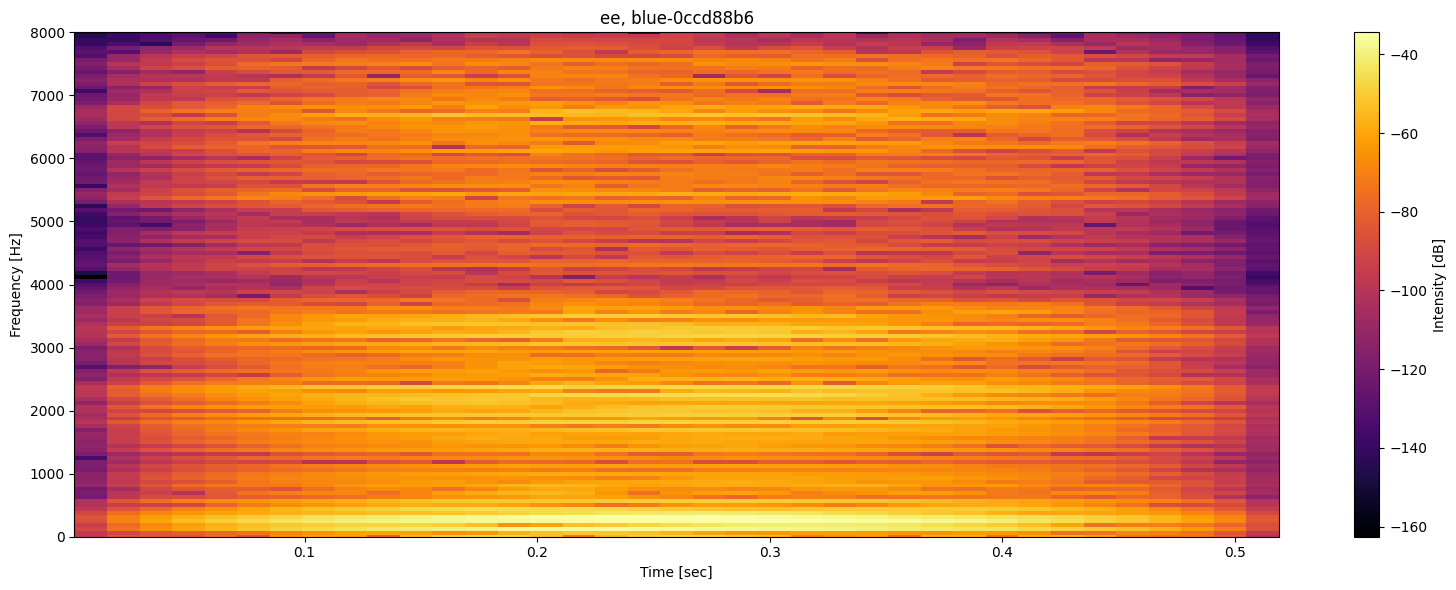

sig_chunks.shape: (32, 65)


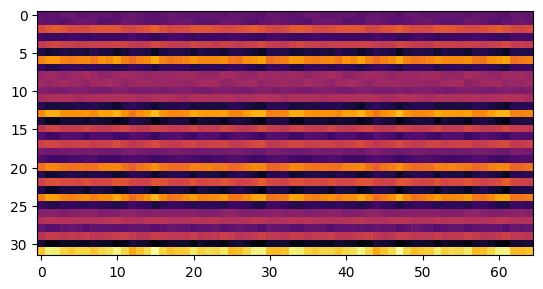

In [127]:
asq_datafolds.viz_random_chunk(vow_split_df, cmap='inferno')



#### TESTS

In [ ]:
# good ones
# autumn
# spring
# winter **
# magma **
# inferno **
# plasma
# viridis